# ResNet

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.utils.data
import torchsummary
import torchvision
import typing
from collections import namedtuple
import sys
import io
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths
import requests

sys.path.insert(0, '..')
import utils
from LearnCV import utils as cvUtils

## Model

https://pytorch.org/hub/pytorch_vision_resnet/

**Model expects:**

1. 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
1. Normalized image with range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


**Model returns:**

Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes.<br>
To get probabilities, you can run a softmax on it.

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
print("submodules:", len(list(model.children())))
torchsummary.summary(model, (3,244,244))

Using cache found in /Users/rapeewannasiri/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


submodules: 10
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14    

## Classification Usage

Source image file: sample-data/AI_dataset_pets/images/Abyssinian_1.jpg
shape: (400, 600, 3)
min/max: 0 245


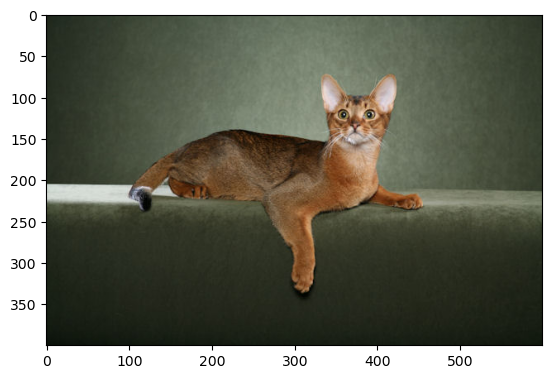

In [5]:
# Load image
# filename = "lena.jpg"
# filename = "baboon.jpg"
# filename = "butterfly.jpg"
# filename = "apple.jpg"
# filename = "HappyFish.jpg"
filename = "Abyssinian_1.jpg"
# filepath = f"sample-data/{filename}"
# filepath = f"sample-data/{filename}"
filepath = f"sample-data/AI_dataset_pets/images/{filename}"
try:
    cvUtils.getCvSample(filename, filepath)
except:
    assert os.path.isfile(filepath), FileNotFoundError(filepath)
print("Source image file:", filepath)

input_image = cv2.imread(filepath)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
plt.imshow(input_image)
print("shape:", input_image.shape)
print("min/max:", np.min(input_image), np.max(input_image))

/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: (3, 224, 336)
min/max: -2.1122026 2.2879462


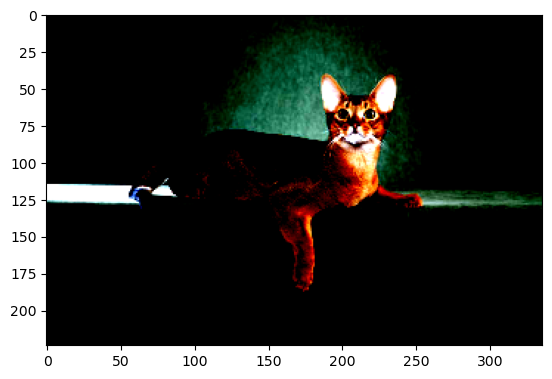

In [6]:
# Pre processing
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
    # torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
plt.imshow(input_tensor.permute(1,2,0))
print("shape:", input_tensor.numpy().shape)
print("min/max:", np.min(input_tensor.numpy()), np.max(input_tensor.numpy()))

In [11]:
# Interfernce and result
model.eval()
with torch.no_grad():
    output = model(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    print("shape:", output[0].shape)
    print("min/max", np.min(output[0].numpy()), np.max(output[0].numpy()))
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print("shape:", probabilities.shape)
    print("min/max", np.min(probabilities.numpy()), np.max(probabilities.numpy()))
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    print(top5_prob, top5_catid)

shape: torch.Size([1000])
min/max -4.927547 6.434926
shape: torch.Size([1000])
min/max 1.0017608e-06 0.0861833
tensor([0.0862, 0.0703, 0.0635, 0.0625, 0.0438]) tensor([876, 285, 904, 237, 435])


In [12]:
# Post processing
res = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt")
if not res.ok:
    raise requests.exceptions.RequestException("Cannot fetch class list")

categories = res.text.split('\n')
print(len(categories))
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

1000
tub 0.08618330210447311
Egyptian cat 0.07025511562824249
window screen 0.06351716816425323
miniature pinscher 0.0625133141875267
bathtub 0.04375186562538147


## Feature Extraion Usage
Extract 512 features from an image.

In [13]:
# Restructure model by removing last layer to get last latent features before the original targets.
submodules = model.children()
featx_model = torch.nn.Sequential(*list(submodules)[:-1])
print("submodules:", len(list(featx_model.children())))
torchsummary.summary(featx_model, (3,244,244))

submodules: 9
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14     

In [14]:
# Interfernce and get 512 features.
featx_model.eval()
with torch.no_grad():
    output = featx_model(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes.
    print("shape:", output[0].shape)
    print("min/max", np.min(output[0].numpy()), np.max(output[0].numpy()))

shape: torch.Size([512, 1, 1])
min/max 0.0 3.3522382


## Arrow Binary Classification Usage


### Model

In [2]:
class ReshapeModule(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), x.size(1))
        return x

In [5]:
submodules = list(model.children())[:-1] + [ReshapeModule(), torch.nn.Linear(512,1)]
arrow_model = torch.nn.Sequential(*submodules)
print("submodules:", len(list(arrow_model.children())))
torchsummary.summary(arrow_model, (3,244,244))

submodules: 11
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14    

### Dataset

In [6]:
Size = namedtuple('ImageSize', ['height', 'width'])
Range = namedtuple('Range', ['min', 'max'])

def genArrow(size: Size, padding: int, lengthRange: Range, thickRange: Range, tipRange: Range, ax: plt.Axes = None) -> np.ndarray:

    img = np.zeros(list(size) + [3], np.uint8)
    img.fill(255)

    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        length = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if length in range(*lengthRange): break
    thick = random.randint(*thickRange)
    color = (0,0,0)
    tipLen = (random.random() * (tipRange[1]-tipRange[0])) + tipRange[0]
    img = cv2.arrowedLine(img, pt1, pt2, color, thick, tipLength=tipLen)

    # center = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    # radius = random.randint(10, min(size)//2)
    # thick = random.randint(*thickRange)
    # color = random.randint(*colorRange)
    # img = cv2.circle(img, center, radius, color, thick)

    # pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    # pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    # thick = random.randint(*thickRange)
    # color = random.randint(*colorRange)
    # img = cv2.rectangle(img, pt1, pt2, color, thick)

    # pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    # pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    # thick = random.randint(*thickRange)
    # color = random.randint(*colorRange)
    # img = cv2.line(img, pt1, pt2, color, thick)

    if ax is not None: ax.imshow(img, 'gray')
    return img

In [7]:
# Pre processing
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
    # torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
size = (128,128) # h,w
padding = 5
lengthRange = (30,100)
thickRange = (1,1)
tipRange = (0.1,0.1)

input_batch = None
for _ in range(64):
    input_image = genArrow(size, padding, lengthRange, thickRange, tipRange)
    input_tensor: torch.Tensor = preprocess(input_image).unsqueeze(0)
    if input_batch is None:
        input_batch = input_tensor
    else:
        input_batch = torch.cat([input_batch, input_tensor])


/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
torch.utils.data.DataLoader()
torch.utils.data.Dataset()

TypeError: DataLoader.__init__() missing 1 required positional argument: 'dataset'

### Forward Model

In [159]:
# Interfernce and get 512 features.
arrow_model.eval()
with torch.no_grad():
    output = arrow_model(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes.
    print("shape:", output.shape)
    print("min/max", np.min(output[0].numpy()), np.max(output[0].numpy()))

shape: torch.Size([64, 1])
min/max 0.25952756 0.25952756


### Train

In [ ]:
epochs = 10
batch_size = 16
lr = 0.01
w_decay = 0.001
m = 0.9
cost_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(arrow_model.parameters(), lr=lr, weight_decay=w_decay, momentum=m)

for e in range(epochs):
    